## <center> <font color='blue'> <b> Predict Stock Price Using LSTMs </b> </font> </center>

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense
import keras.backend as K
from keras.optimizers import SGD, Adam

In [68]:
#!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv

In [69]:
df = pd.read_csv('sbux.csv')

In [70]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [71]:
# get the close price
series = df['close'].values
series

array([28.185, 28.07 , 28.13 , ..., 54.69 , 55.61 , 54.46 ])

In [72]:
series.shape

(1259,)

In [73]:
series = series.reshape(-1,1)
series

array([[28.185],
       [28.07 ],
       [28.13 ],
       ...,
       [54.69 ],
       [55.61 ],
       [54.46 ]])

In [74]:
series.shape

(1259, 1)

In [75]:
# in 1 line
#series = df['close'].values.reshape(-1, 1)

In [76]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2]) # we fit with train data only

series = scaler.transform(series).flatten() # we adjuste everything

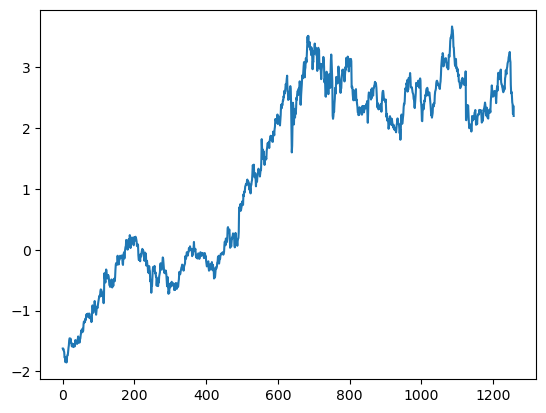

In [77]:
# plot it
plt.plot(series)
plt.show()

In [79]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (1249, 10, 1) Y.shape (1249,)


In [81]:
# split into train and test
X_train, y_train = X[:-N//2], Y[:-N//2]
X_test, y_test = X[-N//2:], Y[-N//2:]

X_train.shape, y_train.shape

((624, 10, 1), (624,))

### Model 1

In [83]:
def build_compile_model_1(T=T):
    i = Input(shape=(T, 1))

    # one LSTM
    x = LSTM(5)(i)

    x = Dense(1)(x)
    model = Model(i, x)
    model.compile(
      loss='mse',
      optimizer=Adam(learning_rate=0.01),
    )
    
    return model

model_1 = build_compile_model_1()

In [84]:
# train the RNN
r1 = model_1.fit(
  X_train, y_train,
  epochs=80,
  verbose=0,
  validation_data=(X_test, y_test),
)

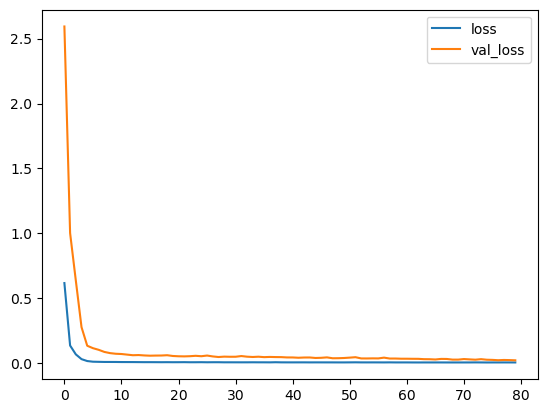

In [85]:
# Plot loss per iteration
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### One step forecast

In [88]:
# Make predictions
Ptrain = model_1.predict(X_train)
Ptest = model_1.predict(X_test)

20/20 [==============================] - 0s 2ms/step


In [91]:
Ptrain[0], y_train[0]

(array([-1.738874], dtype=float32), -1.8550616725763345)

In [93]:
# inverse transform
# remember we transform series (is a time series problem)
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
Ptrain2 = scaler.inverse_transform(Ptrain.reshape(-1, 1)).flatten()
Ptest2 = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [95]:
# now they are in the original range
Ptrain2[0], y_train2[0]

(27.402962, 26.605)

In [96]:
# Print the MAE
print("lstm train mae:", mae(Ytrain2, Ptrain2))
print("lstm test mae:", mae(Ytest2, Ptest2))

lstm train mae: 0.3542810279895099
lstm test mae: 0.7460234692382812


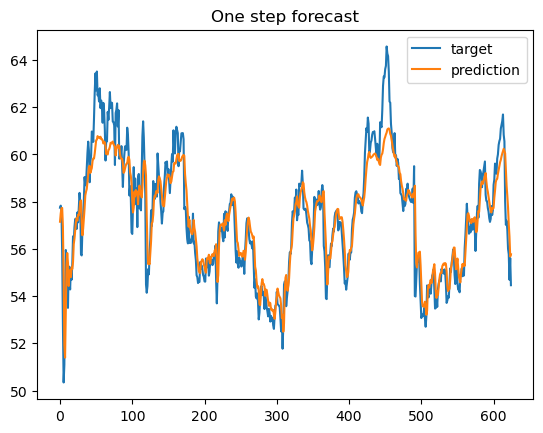

In [98]:
# plot
plt.plot(y_test2, label='target')
plt.plot(Ptest2, label='prediction')
plt.legend()
plt.title("One step forecast")
plt.show()

#### Multiple step forecast

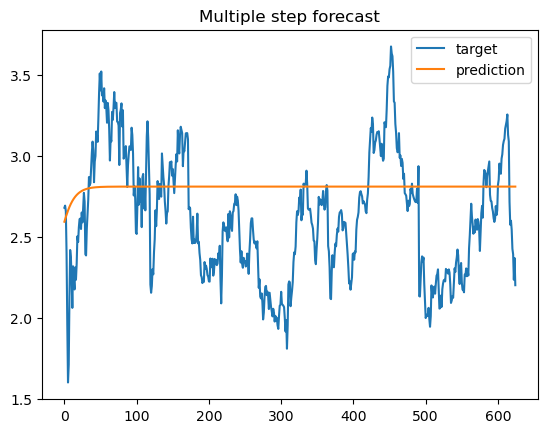

In [106]:
# right forecast
forecast = []
input_ = X_test[0]


while len(forecast) < len(y_test):
  f = model_1.predict(input_.reshape(1, T, 1), verbose=0)[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(y_test, label='target')
plt.plot(forecast, label='prediction')
plt.legend()
plt.title("Multiple step forecast")
plt.show()

Not very good results.

### Model 2